In [97]:
import pandas as pd
import zipfile
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
zip_path = os.path.join(os.getcwd(),'bond_data.zip')
dfs={}

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.startswith('bond_data/') and file_name.endswith('.csv'):
            with zip_ref.open(file_name) as f:
                dfs[file_name.split('/')[-1]] = pd.read_csv(f)

prices_df = dfs['prices.csv']
yields_df = dfs['yields.csv']
yields_df.set_index(pd.to_datetime(yields_df['time'], unit='ms'), inplace=True)
prices_df.set_index(pd.to_datetime(prices_df['time'], unit='ms'), inplace=True)

In [ ]:
complete_df = pd.merge(prices_df, yields_df, left_index=True, right_index=True, how='inner')

(12787, 12787)

# Generation of Bond Data 

In [72]:
bond_list = [{
        'Principal' : 100,
        'Coupon Rate' : '8%',
        'Coupon Frequency' : 'Semi-annual',
        'Time To Maturity (years)' : 4.5
    }]
bond_list.append({
        'Principal' : 100,
        'Coupon Rate' : '5%',
        'Coupon Frequency' : 'Annual',
        'Time To Maturity (years)' : 7
    })
bond_data = pd.DataFrame(bond_list)

bond_data

,Principal,Coupon Rate,Coupon Frequency,Time To Maturity (years)
0,100,8%,Semi-annual,4.5
1,100,5%,Annual,7.0


In [113]:
#Spot Curve : 
spot_curve_6m = [0.027, 0.0285, 0.029, 0.0302, 0.0313, 0.032, 0.0324, 0.033, 0.0335, 0.0339, 0.0342, 0.0345, 0.0347, 0.035]



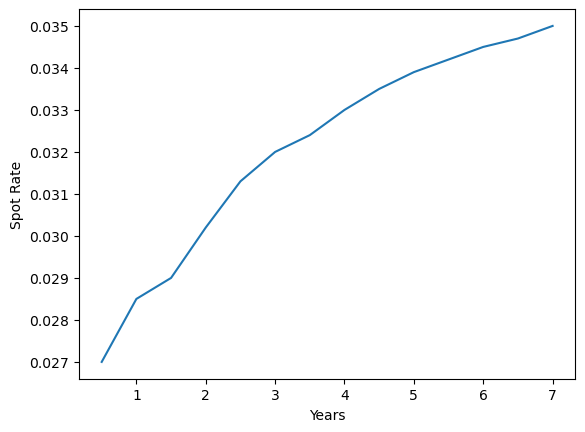

In [114]:
x = np.arange(0.5, 7.5, 0.5)
plt.plot(x, spot_curve_6m)
plt.ylabel('Spot Rate')
plt.xlabel('Years')
plt.xticks(np.arange(1,8));

In [78]:
def clean(data) : 
    df = data.copy()
    df['Coupon Rate'] = df['Coupon Rate'].astype(str).str.replace('%', '').astype(int)
    freq_map = {
        'Annual' : 1,
        'Semi-annual' : 1/2, 
        'Quarterly' : 1/4
    }
    df['Coupon Frequency'] = df['Coupon Frequency'].replace(freq_map).astype(float)
    df['Nb Coupons'] = df['Time To Maturity (years)']/df['Coupon Frequency']
    return df
df = clean(bond_data)

/var/folders/f7/krq4wgqx3gx1gxzm3td0hqvr0000gn/T/ipykernel_41065/645196800.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Coupon Frequency'] = df['Coupon Frequency'].replace(freq_map).astype(float)


In [175]:
def bond_pricer(data,yield_curve):
    df = data.copy()
    for i in range(len(df)):
        bp = 0
        coupon = df.iloc[i,1]*df.iloc[i,2] #Coupon Rate * Coupon Frequency 
        for j in range((df.iloc[i,4]).astype(int)):
            bp += coupon*np.exp(-yield_curve[j]*(j+1)/2)
        bp+= df.iloc[i,0]*np.exp(-yield_curve[(df.iloc[i,4].astype(int))-1]*df.iloc[i,3])
        df.loc[i,'Bond Price'] = bp
    return df
df_with_price = bond_pricer(df, spot_curve_6m)

In [164]:
df_with_price.head()


,Principal,Coupon Rate,Coupon Frequency,Time To Maturity (years),Nb Coupons,Bond Price
0,100,8,0.5,4.5,9.0,119.285100
1,100,5,1.0,7.0,7.0,112.624539


In [177]:
bond_pricer(df,spot_curve_6m).loc[0,'Bond Price']

119.28510015321632

In [186]:
def yield_finder(data) : 
    for i in range(len(data)):
        y=0.002
        bp=0
        market_price = data.loc[i,'Bond Price']
        principal = data.loc[i,'Principal']
        n = data.loc[i,'Time To Maturity (years)']
        rate_adjuster = data.loc[i,'Coupon Frequency']
        coupon = data.loc[i,'Coupon Rate']*rate_adjuster
        nb_coupon = data.loc[i,'Nb Coupons']
        while np.abs(bp-market_price) > 0.5:
            bp = coupon*((1-(1+y*rate_adjuster)**-nb_coupon)/(y*rate_adjuster))+principal/((1+y*rate_adjuster)**n)
            y+=0.0001
        data.loc[i,'Yield'] = round(y*100,2)
    return df
yield_finder(df_with_price)

,Principal,Coupon Rate,Coupon Frequency,Time To Maturity (years),Nb Coupons,Yield To Maturity
0,100,8,0.5,4.5,9.0,3.330
1,100,5,1.0,7.0,7.0,0.002


In [171]:
df_with_price

,Principal,Coupon Rate,Coupon Frequency,Time To Maturity (years),Nb Coupons,Bond Price
0,100,8,0.5,4.5,9.0,119.285100
1,100,5,1.0,7.0,7.0,112.624539
